### Instituto Superior de Engenharia de Lisboa

## Classificação e Autenticação Biométrica com sinais de eletrocardiograma  (ECG)

#### Data de Entrega: 12 de novembro de 2024

### Alunos:
- Ana Sofia Oliveira (39275)
- Eduardo Santos (40610)

____________________

## Indice
1. [Introdução](#into)
2. [Configurações Iniciais](#conf)
   * [Imports](#imports)
3. [Conjunto de Dados](#conf)
   * [Dados - PhysioNet](#pnet)
   * [Dados - Alunos](#alunos)
4. [Análise do Dados](#analise)
   * [Dados](#dados) 
   * [Visualização](#ver)
5. [Pré-Processamento](#pre_pros)
   * [Filtragem, Deteção de picos e Segmentação](#fil) 
   * [Templates](#Templates) 
   * [Outlier Detection](#o_det)
   * [load balancing](#loadb)
   * [Template Detection](#t_det)
6. [Classificação](#classificacao)
   * [Train & Test](#train_test) 
   * [Classificadores](#classificadores) 
7. [Avaliação](#Avaliacao)
8. [Resultados](#resultados)


## 1. Introdução <a id="into"></a>

##### A utilização de sistemas biométricos está cada vez mais presente no nosso dia a dia, desde a autenticação em telemóveis, sistemas de controlo de ponto, acesso a áreas seguras entre outros. Existem diversos sistemas com diferentes métodos de identificar pessoas para os mais diversos contextos. 
##### O desafio nesta área encontra-se a robustez, segurança e aceitabilidade por partes dos utilizadores, como exemplo da impressão digital no telemóvel que é aceite bastante bem pelas pessoas. Além disso, o tratamento de dados biométricos e segurança da informação é uma questão essencial, principalmente em dados fisiológicos tal como ECG e PPG que devem ser geridos e de forma segura, assegurando a privacidade dos utilizadores.

### Contexto

##### Neste projeto, exploramos os conceitos de identificação e autenticação utilizando sinais ECG, no contexto da unidade curricular de Sistemas Biométricos. Os conjuntos de dados utilizados, são provenientes da base de dados da PhysioNet e de registos de alunos que pertencem à unidade curricular, recolhidos de forma anónimo e consentimentos para todos os participantes.

## 2. Configurações Inicias <a id="conf"></a>

##### Nesta secção são definidas as dependências funcionais e estruturais do projeto. O projeto proposto depende funcionalmente da utilização das bibliotecas importadas na sub-secção Imports, e estruturalmente das funções auxiliares criadas durante o seu desenvolvimento. 

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from wfdb import rdsamp
from os import listdir
from biosppy.signals import ecg
from biosppy.clustering import outliers_dmean, mdist_templates
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score

## 3. Conjuntos de dados

####  Os dados utilizados para este projeto estão divididos em dois conjuntos:
- [PhysioNet](https://physionet.org/content/ecgiddb/1.0.0/.) - Conjunto de registo ECG disponibilizados pela PhysioNet.
- Alunos - Conjunto de registo ECG disponibilizados pelos alunos.

> Nota: Deve correr apenas um dos conjuntos de dados par defenir os dados a utilizar e grantir que o caminho para os dados é o correto.

### Dados - PhysioNet <a id="pnet"></a>

#### Funções Auxiliares para a leitura dos dados da PhysioNet , é possível definir o caminho para a pasta do respetivo conjunto de dados ou limitar o número de pessoas e records a ser utilizado. Pensando no conjunto de treino e teste do sistema, os dados foram divididos por registos, assegurando uma maior generalização dos dados. Como o sinal ECG tende a ser repetitivo ao longo do tempo. No entanto, diferenças significativas podem surgir entre registos dos mesmos indivíduos se forem captados em dias diferentes. Deforma a garantir essa generalização, os dados foram separados numa proporção de 50/50, com base no número de registos de cada indivíduo.

In [2]:
dataset_path = "./data/ecg_id" # path to the dataset
person_path = '{}/Person_{:02}'
record_path = '{}/rec_{}'
numb_persons = 90

def get_numb_records(path) -> int: 
    repeat = 3 # number of files per record
    numb_of_files = len(listdir(path))
    return int(numb_of_files/repeat) 

def load_data(path):
    paths = [(person_path.format(dataset_path, i+1), i) for i in range(0, numb_persons)] # or [1,2,4]
    data = [
        (rdsamp(record_path.format(path, r)), p) 
                for path, p in paths 
                    for r in range(1, get_numb_records(path) + 1) # or [1,2,3]
    ]
    train = []
    test = []
    for i in range(len(data)):
        if i % 2 == 0:
            train.append(data[i])
        else:
            test.append(data[i])

    numb_persons_train = len(np.unique([d[1] for d in train]))
    numb_persons_test = len(np.unique([d[1] for d in test]))

    return train, test, numb_persons_train, numb_persons_test

#### Leitura do conjunto de dados da physionet, conforme a documentação é possível obter sinal "raw" de cada indivíduo, juntamente com frequência em que os dados foram adquiridos. Além disso, este conjunto já contem os sinais ECG filtrados.

In [3]:
data_train, data_test, numb_persons_train, numb_persons_test = load_data(dataset_path.format(1))
signal, fields  = data_train[0][0]
raw_data_train = [(s[:,0], p) for ((s,f), p) in data_train]
filtered_data_train = [(s[:,1], p) for ((s,f), p) in data_train]
raw_data_test = [(s[:,0], p) for ((s,f), p) in data_test]
filtered_data_test = [(s[:,1], p) for ((s,f), p) in data_test]
fs = fields['fs'] # frequency

### Dados - Alunos <a id="alunos"></a>

#### Funções Auxiliares para a leitura dos dados dos alunos, é possível definir o caminho para a pasta do respetivo conjunto de dados ou limitar o número de pessoas e records a ser utilizado. Pensando no conjunto de treino e teste do sistema, os dados foram divididos por dois registos feitos em dias distintos. Para aumentar o desafio deste conjunto de dados, há também alunos com apenas um registo disponível, acrescentando uma generalidades dos dados. 

In [4]:
dataset_path = "./data/SB_ECGDatabase_0{}" # path to the dataset

def load_data(dataset_path):
    records = listdir(dataset_path)
    numb_persons = len(records)
    data = [
        (np.loadtxt('{}/{}'.format(dataset_path, record)), 
         int(record.split('_u')[1].split('.')[0])) 
                 for record in records
    ]
    return data, numb_persons

data_train, numb_persons_train = load_data(dataset_path.format(1))
data_test, numb_persons_test = load_data(dataset_path.format(2))

#### Leitura do conjunto de dados dos alunos, é possível obter sinal "raw" de cada indivíduo com frequência em que os dados foram adquiridos.

In [5]:
signal = data_train[0][0]
raw_data_train = [(s[:,1], p) for (s, p) in data_train]
raw_data_test = [(s[:,1], p) for (s, p) in data_test]
filtered_data_train = []
fs = 1000

## 3. Conjuntos de dados

##### No contexto de inteligência artificial, e para a resolução de problemas de classificação, é necessário efetuar uma boa análise dos dados e pré-processamento para promover uma boa classificação.


### Dados <a id="dados"></a>

In [6]:
table_header = ['','Number of Persons', 'FS (hz)', 'Sample time (sec)', 'Número de registos']
table_data = [
    ['Train', numb_persons_train, fs, raw_data_train[0][0].shape[0]/fs, len(raw_data_train)],
    ['Test', numb_persons_test, fs, raw_data_test[0][0].shape[0]/fs, len(raw_data_test)],
]

table_string = tabulate(table_data, headers=table_header, tablefmt="grid")

print(table_string )

+-------+---------------------+-----------+---------------------+----------------------+
|       |   Number of Persons |   FS (hz) |   Sample time (sec) |   Número de registos |
+=======+=====================+===========+=====================+======================+
| Train |                  21 |      1000 |                65.6 |                   21 |
+-------+---------------------+-----------+---------------------+----------------------+
| Test  |                  19 |      1000 |                69.5 |                   19 |
+-------+---------------------+-----------+---------------------+----------------------+


   ### Visualização <a id="ver"></a>

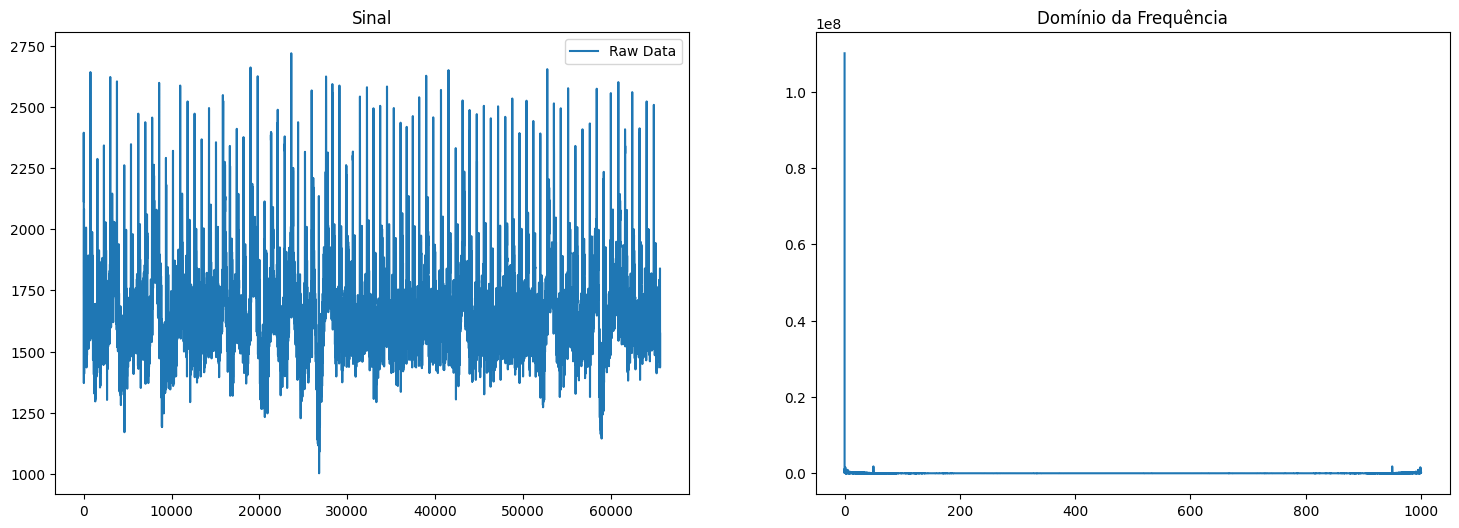

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].set_title('Sinal')
axes[0].plot(raw_data_train[0][0], label='Raw Data') 
if len(filtered_data_train) > 0:
    axes[0].plot(filtered_data_train[0][0], label='Filtered Data')
axes[0].legend()

X = np.fft.fft(raw_data_train[0][0])
freq = np.arange(len(X))/len(X)*fs
axes[1].set_title('Domínio da Frequência')
axes[1].plot(freq,np.abs(np.abs(X)))


plt.show()

## 3. Pré-Processamento <a id="pre_pros"></a>

#### Antes de treinar qualquer modelo, é fundamental realizar um bom pré-processamento, uma vez que este processo pode melhorar significativamente os resultados e eficiência do classificador, tendo em consideração o contexto do problema. Neste projeto, optámos por explorar técnicas de remoção de outliers e template selection, para melhorar qualidade dos sinais ECG mantendo a sua generalidade, e o balanceamento entre classes através do seu balanceamento, e com este processo aumentar o desempenho dos classificadores.

### Filtragem, Deteção de picos e Segmentação <a id="fil"></a>

#### A filtragem do sinal ECG é fundamental para remover o ruído que possa existir, frequentemente provocada pela corrente elétrica existente no local da aquisição dos dados, provocando interferências de alta frequência.
#### Para identificar as ondas QRS, recorre-se à deteção de picos R, este método permite localizar os batimentos cardíacos. Em que os mesmo segmentados, resultam dos ciclos individuais de cada registo, que facilita o processo de análise e extração de características. Este é apenas um processo fiducial, entre outras abordagens possíveis de obtenção de caracterizas relevantes para classificação de identificação e autenticação. Neste projeto, utilizámos a biblioteca BioSPPy para realizar a filtragem, deteção de picos e segmentação.

In [8]:
def get_templates(raw_data, fs):
    outs = [ (ecg.ecg(signal=s, sampling_rate=fs, show=False), p) for ((s), p) in raw_data]
    return outs

outs_tain = get_templates(raw_data_train, fs)
outs_test = get_templates(raw_data_test, fs)

### Templates

#### Após a segmentação, obtemos um conjunto de templates de cada ciclo cardíaco. Este processo é repetido para todos os registos de cada participante, que capturam as variações individuais do sinal ECG ao longo do tempo.

In [9]:
def parse_outs(outs):
    labels = np.hstack([p for out, p in outs for _ in range(out["templates"].shape[0])])
    templates = np.vstack([ out["templates"] for out, _ in outs])
    return (templates, labels)


templates_tain, labels_tain = parse_outs(outs_tain)
templates_test, labels_test = parse_outs(outs_test)

#### Através deste conjunto, é possível analisar os dados de forma geral, considerando que existem participantes com diferentes números de registos diferentes e durações distintas, resultando em variações de dados para cada participante. A nível da classificação irá resultar num problema de balanceamento de dados, que tem de ser considerado. Juntamente com as quantidades significativas de dados necessários para identificação e autenticação, assumindo que se precisarmos de 300 a 600 atributos por cada um dos templates,  poderá haver a necessidade de utilizar técnicas de redução ou seleção de atributos.

In [10]:
table_header = ['','Number of templates','Number of features', 'Number of labels']
table_data = [
    ['Train', templates_tain.shape[0], templates_tain.shape[1], labels_tain.shape[0]],
    ['Test', templates_test.shape[0], templates_test.shape[1], labels_test.shape[0]],
]

table_string = tabulate(table_data, headers=table_header, tablefmt="grid")

print(table_string )

+-------+-----------------------+----------------------+--------------------+
|       |   Number of templates |   Number of features |   Number of labels |
+=======+=======================+======================+====================+
| Train |                  1911 |                  600 |               1911 |
+-------+-----------------------+----------------------+--------------------+
| Test  |                  1640 |                  600 |               1640 |
+-------+-----------------------+----------------------+--------------------+


#### Uma boa análise envolve avaliar para cada um dos indivíduos, a sobreposição dos templates, uma vez que o sinal ECG tende a manter os mesmo padrões ao longo do tempo, podendo haver variações derivados a fatores de stress, condições de saúde ou movimentos que são feitos durante a aquisição, entre outros aspetos.  Os próximos passo visam e melhor e remover templates que podem comprometer a generalidade do sinal, assim como dados que irrelevantes para a classificação no contexto de identificação e autenticação.

> Nota: É possível selecionar diferentes participantes usando o respetivo número de identificação. Sugerimos os números 13 e 15 para esta análise, por serem visivelmente piores, o que ajuda ilustrar o problema.


(72, 600)


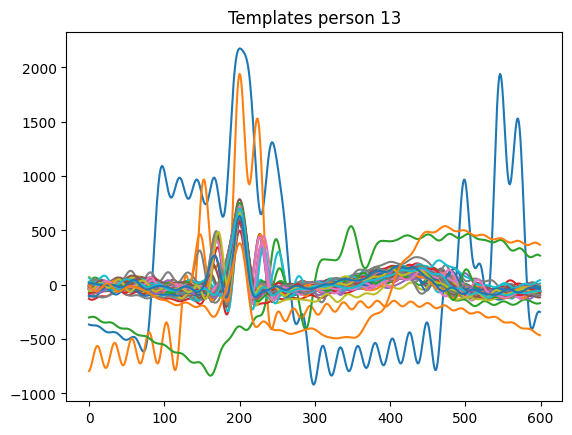

In [11]:
person_number = 13 #15
templates_person = templates_tain[labels_tain == person_number]

print(templates_person.shape)

plt.plot(templates_person.T)
plt.title('Templates person {}'.format(person_number))
plt.show()

## Outlier Detection <a id="o_det"></a>

#### A identificação de outliers no contexto de sinais ECG, tem a finalidade de detetar valores atípicos no sinal.  Dependendo do contexto do problema, esses valores podem ter diferentes relevâncias. No caso do de identificação e autenticação, esses valores não são relevantes para o problema. No entanto, no caso de deteção de patologias, esses valores atípicos podem ser essenciais para o problema. 

#### Neste projeto, optámos por utilizar o algoritmo dmean disponibilizado pela biblioteca BioSPPy. Este algoritmo identifica outliers com base na distância euclidiana relativamente à média dos dados.  Os valores são considerados atípicos através de um limiar decisão parametrizado através dos parâmetros alpha e beta.



In [12]:
def remove_outliers(templates, labels, alpha = 0.5, beta = 1.5):
    unique_labels = np.unique(labels)
    new_labels = np.array([])
    new_labels_out = np.array([])
    new_templates = []
    new_templates_out = []
    for l in unique_labels:
        temp = templates[labels == l] # templates de um label
        out = outliers_dmean(data=temp, alpha=alpha, beta=beta) # detectar outliers D-Mean 
        idx = out['clusters'][0] # indices dos templates que não são outliers
        idx_out = out['clusters'][-1] # indices dos templates que são outliers
        new_labels = np.hstack((new_labels, labels[labels == l][idx]))
        new_labels_out = np.hstack((new_labels_out, labels[labels == l][idx_out]))
        new_templates.append(temp[idx])
        new_templates_out.append(temp[idx_out])
        
    new_templates = np.vstack(new_templates)
    new_templates_out = np.vstack(new_templates_out)
    return (new_templates, new_labels, new_templates_out, new_labels_out)



templates_test, labels_test = parse_outs(outs_test)
templates_tain_out, labels_tain_out, templates_tain_out_removed, labels_tain_out_removed = remove_outliers(templates_tain, labels_tain)
templates_test_out, labels_test_out, templates_test_out_removed, labels_test_out_removed = remove_outliers(templates_test, labels_test)

#### Após utilização do algoritmo dmean, e tendo em consideração que os parâmetros utilizados devem ser testados e avaliados no contexto do problema, analisando os resultados e impacto nos dados obtidos. Por consequência desta abordagem, iremos reduzir o número de dados utilizados, isso pode ser algo útil no sentido em que podemos limitar e avaliar os registos de forma individual e caso não cumpra um determinado critério, o mesmo registo pode não ser aceite no processo "enroll", garantido assim uma validação dos dados. 

In [13]:
table_header = ['','Number of templates','Number of features', 'Number of labels']
table_data = [
    ['Train', templates_tain_out.shape[0], templates_tain_out.shape[1], labels_tain_out.shape[0]],
    ['Test', templates_test_out.shape[0], templates_test_out.shape[1], labels_test_out.shape[0]],
]

table_string = tabulate(table_data, headers=table_header, tablefmt="grid")

print(table_string )

+-------+-----------------------+----------------------+--------------------+
|       |   Number of templates |   Number of features |   Number of labels |
+=======+=======================+======================+====================+
| Train |                  1565 |                  600 |               1565 |
+-------+-----------------------+----------------------+--------------------+
| Test  |                  1361 |                  600 |               1361 |
+-------+-----------------------+----------------------+--------------------+


#### Em resumo, ao aplicarmos este algoritmo e analisarmos os resultados individualmente, Obsersar claras melhorias na qualidade dos templates selecionados, e comparar as diferenças entre ambos. No contexto deste projeto queremos preservar os templates que garantam as caracterizais principais do sinal original.

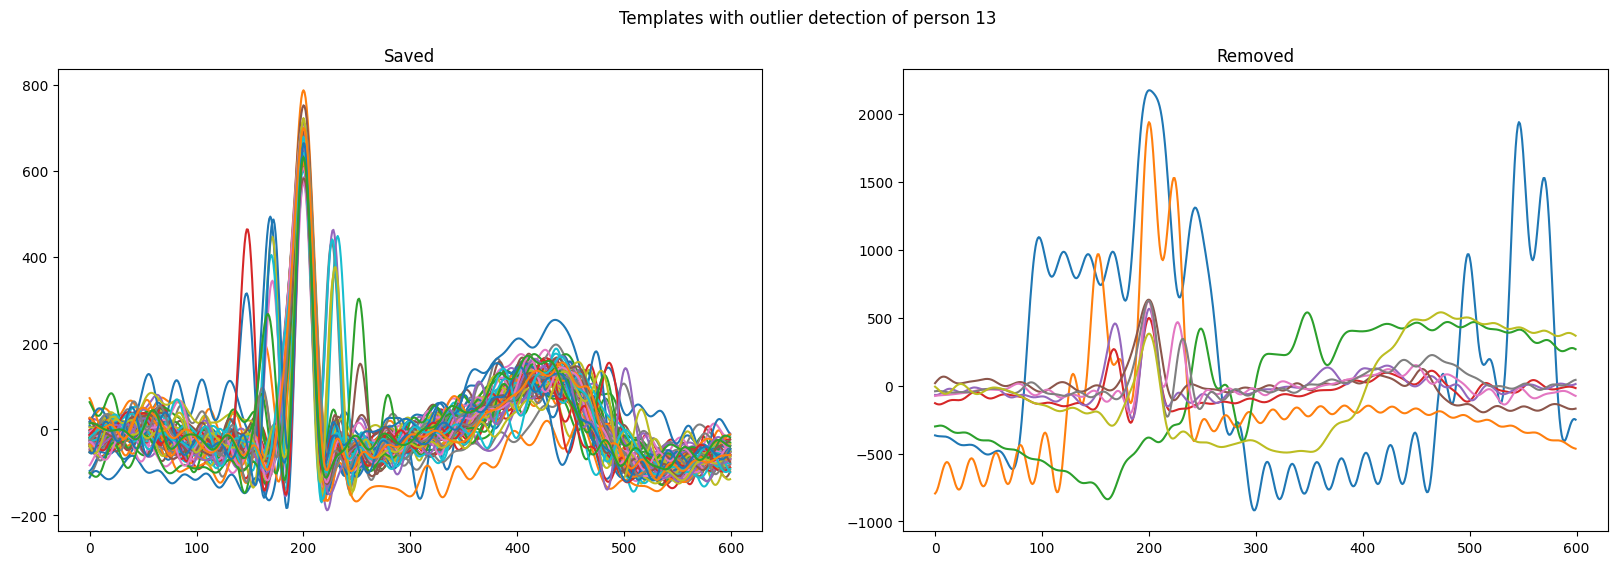

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))


axes[0].set_title('Saved')
axes[0].plot(templates_tain_out[labels_tain_out == person_number].T)

axes[1].set_title('Removed')
axes[1].plot(templates_tain_out_removed[labels_tain_out_removed == person_number].T)

plt.suptitle('Templates with outlier detection of person {}'.format(person_number))
plt.show()


## Load Balance <a id="loadb"></a>

#### A análise do balanceamento dos dados no contexto do problema deste é projeto é relevante, pois uma distribuição não balanceada entre indivíduos podem influenciar os resultados, principalmente quando alguns participantes possuem menos registos. 
#### Ajustar o número de dados de cada utilizador ajuda a mitigar esse balanceamento e melhora a fiabilidade do modelo. Neste sentido,com base no número templates definidos e antevendo a seleção dos melhores templates, determina-se o número mínimo de templates por indivíduo, aplicando uma percentagem de templates a remover. 

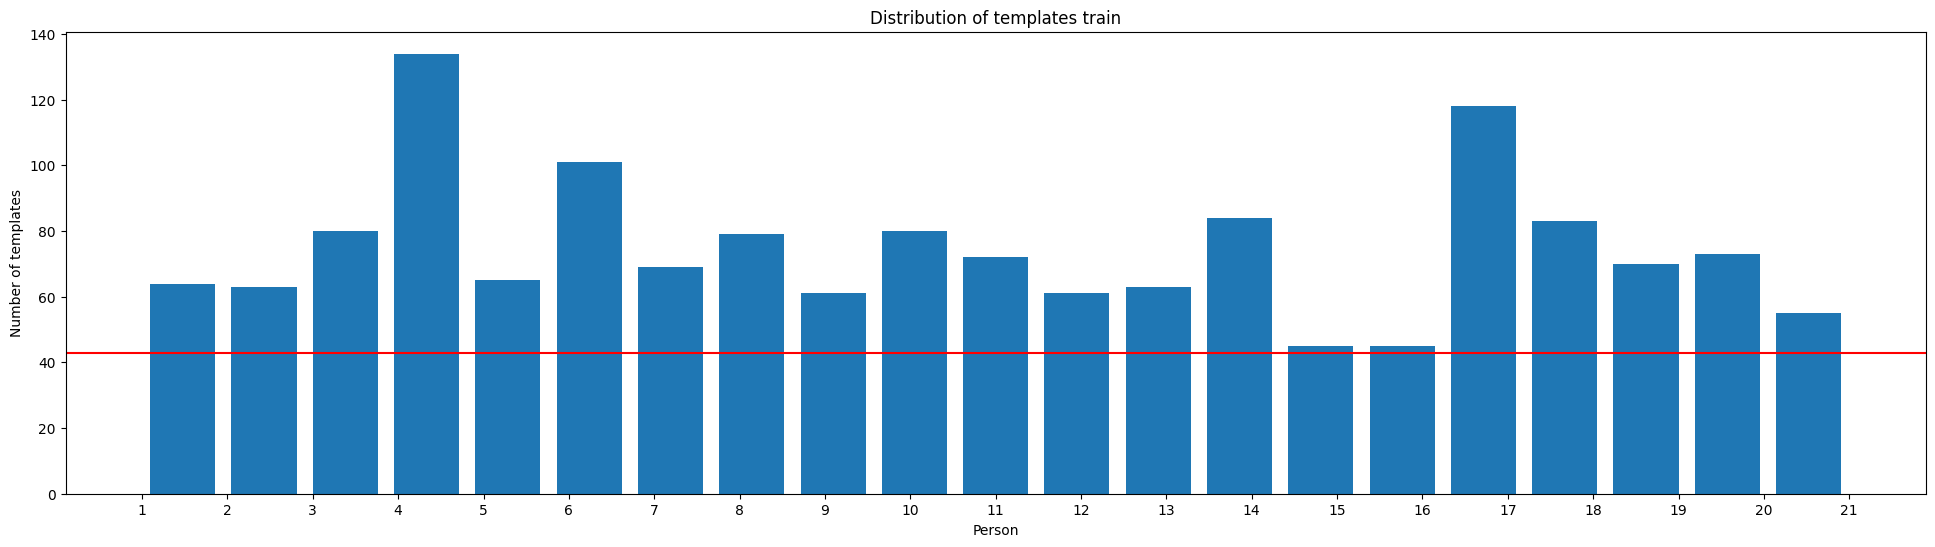

In [15]:
percentage = 0.95
labels_train, labels_count = np.unique(labels_tain_out, return_counts=True)
nTemplates_train = round(labels_count.min() * percentage)

plt.figure(figsize=(24, 6))
plt.title('Distribution of templates train')
plt.xlabel('Person')
plt.ylabel('Number of templates')
plt.xticks(ticks=labels_train)
plt.axhline(y=nTemplates_train, color='r', label=f'Number min of templates {nTemplates_train}')
plt.hist(labels_tain_out, bins=numb_persons_train, rwidth=0.8)
plt.show()

## Template Selection <a id="loadb"></a>

#### De forma a melhor a eficiência dos classificador e garantir os dados apenas mais representativos optamos por utilizar a seleção de templates.  Para isso foi utilizado o algoritmo Mdist do BioSppy que permite identificar e selecionar os templates mais relevantes para o processo de classificação.

In [16]:
def template_selection(templates, labels, nTemplates=None, metric = 'euclidean', percentage = 0.9):
    unique_labels = np.unique(labels)
    new_labels_sel = np.array([])
    new_templates_sel = []

    for l in unique_labels:
        temp = templates[labels == l]
        if nTemplates is None:
            nTemplates = round(temp.shape[0] * percentage) 
        out = mdist_templates(data=temp, ntemplates=nTemplates, metric=metric) # template selection m_dist
        new_templates_sel.append(out['templates'])
        new_labels = np.ones(len(out['templates']))*l
        new_labels_sel = np.hstack((new_labels_sel, new_labels))
        
    new_templates_sel = np.vstack(new_templates_sel)
    return (new_templates_sel, new_labels_sel)

templates_tain_sel, labels_tain_sel = template_selection(templates_tain_out, labels_tain_out, nTemplates=nTemplates_train)
templates_test_sel, labels_test_sel = template_selection(templates_test_out, labels_test_out, percentage=percentage)

#### Em consequência desta abordagem, houve uma redução significativa na quantidade de dados utilizados. No entanto, conseguimos garantir que os dados selecionados são os mais relevantes, mantendo balanceamento entre classes é igual para cada uma das classes.

In [17]:
table_header = ['','Number of templates','Number of features', 'Number of labels']
table_data = [
    ['Train', templates_tain_sel.shape[0], templates_tain_sel.shape[1], labels_tain_sel.shape[0]],
    ['Test', templates_test_sel.shape[0], templates_test_sel.shape[1], labels_test_sel.shape[0]],
]

table_string = tabulate(table_data, headers=table_header, tablefmt="grid")

print(table_string )

+-------+-----------------------+----------------------+--------------------+
|       |   Number of templates |   Number of features |   Number of labels |
+=======+=======================+======================+====================+
| Train |                   903 |                  600 |                903 |
+-------+-----------------------+----------------------+--------------------+
| Test  |                  1110 |                  600 |               1110 |
+-------+-----------------------+----------------------+--------------------+


####  É possível também confirmar a qualidade dos resultados para cada participante.

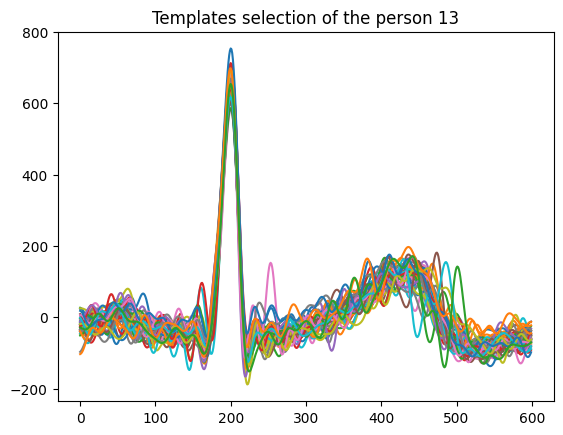

In [18]:
plt.title('Templates selection of the person {}'.format(person_number))
plt.plot(templates_tain_sel[labels_tain_sel == person_number].T)
plt.show()

## 6. Classificação <a id="classificacao"></a>



6. [Classificação](#classificacao)
   * [Train & Test](#train_test) 
   * [Classificadores](#classificadores) 



### Train & Test <a id="train_test"></a>

#### Antes de treinar o classificador, é importante preparar os dados. Para isso, utilizamos uma validação cruzada estratificada, garantindo múltiplos "folds" e a divisão equilibrada entre classes nos conjuntos de treino e validação. O conjunto de treino está definido por 80% dos dados, enquanto o conjunto de validação corresponde aos restantes 20%.

In [19]:
X_train, y_train = templates_tain_sel, labels_tain_sel
X_test, y_test = templates_test_sel, labels_test_sel
n = 5

folds = StratifiedShuffleSplit(n_splits=n, test_size=0.2, random_state=0)

#### No entanto, para o problema binário, os dados não estavam balanceados devido ao número elevado de exemplos para cada uma das classes. Para resolver isso, foi utilizado um Under Sampler para garantir o balanceamento entre as classes. A classificação binária é definida por um indivíduo, sendo que as classes negativas são representadas pelas restantes classes.

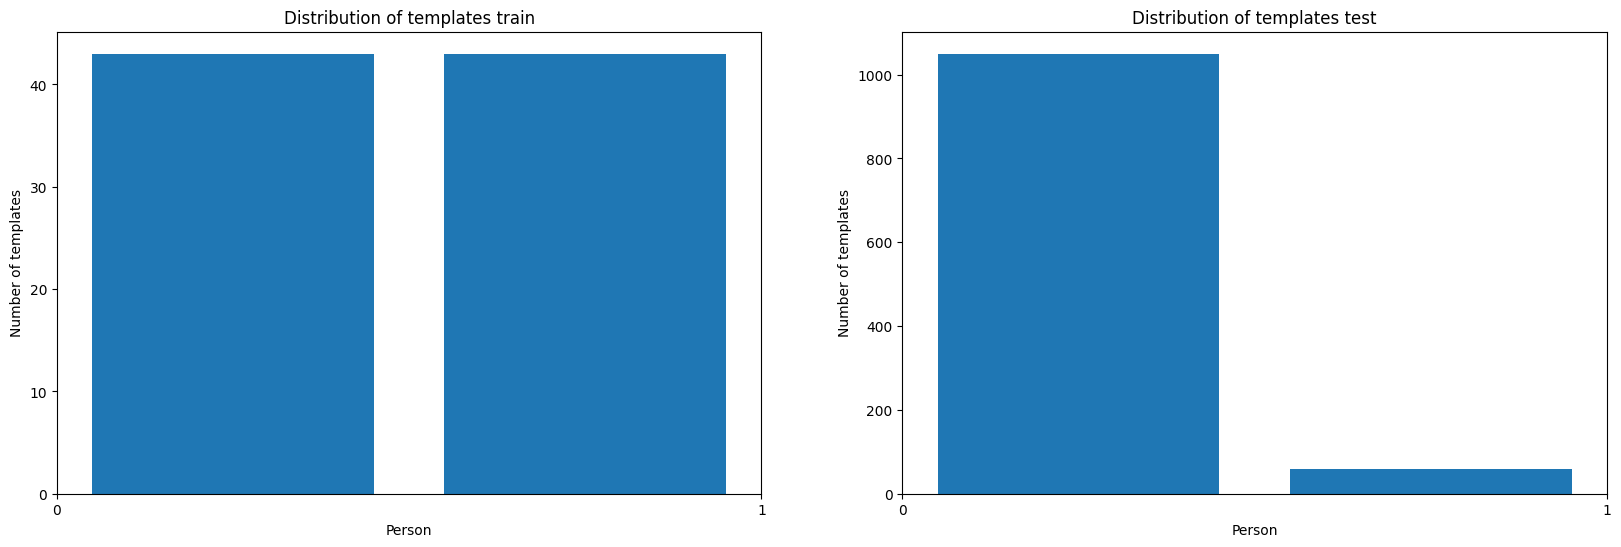

In [20]:
person = person_number

labels_names = np.unique(y_train)

y_train_bin = y_train.copy()
y_train_bin[y_train == person] = 1
y_train_bin[y_train != person] = 0
y_test_bin = y_test.copy()
y_test_bin[y_test == person] = 1
y_test_bin[y_test != person] = 0

X_train_bin, y_train_bin = RandomUnderSampler(random_state=0).fit_resample(X_train, y_train_bin)

labels_names = np.unique(y_train)

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

counts1, bins1, patches1  = axes[0].hist(y_train_bin, bins=2, rwidth=0.8)
axes[0].set_title('Distribution of templates train')
axes[0].set_xticks([bins1[0], bins1[-1]])
axes[0].set_xticklabels(['0', '1'])
axes[0].set_xlabel('Person')
axes[0].set_ylabel('Number of templates')


counts2, bins2, patches2 = axes[1].hist(y_test_bin, bins=2, rwidth=0.8)
axes[1].set_title('Distribution of templates test')
axes[1].set_xticks([bins2[0], bins2[-1]])
axes[1].set_xticklabels(['0', '1'])
axes[1].set_xlabel('Person')
axes[1].set_ylabel('Number of templates')


plt.show()



### Classificadores <a id="classificadores"></a>

#### Neste projeto foi escolhido os classificadores KNN e SVM devido à sua capacidade de lidar com dados complexos e padrões não lineares, os mesmos serão testados com vários parâmetros para diferentes flods, de modo obter os melhors resultados possiveis, utilizamos também uma estratégia de um contra todos, através do SVM para testar os seus resultados em comparação com um único modelo.

In [21]:
parametersKnn  = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan']
}

parametersSVM  = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

parametersSVMRest = {}

knn = KNeighborsClassifier()

svm = SVC(probability=True)

ovr = OneVsRestClassifier(SVC(C=1, gamma=1, kernel='linear', probability=True))

## 7. Avaliação <a id="avaliacao"></a>

#### Para a avaliação dos resultados, utilizámos um grid search para definir os melhores parâmetros para cada classificador, em seguida, testámos o modelo com os dados de teste, que consistem em registros realizados em diferentes períodos. Este método permite melhorar a eficácia e a fiabilidade dos resultados obtidos.

#### Funçoes Auxiliares para métricas de teste:

In [22]:


def print_scores(grid_search,X, y, figsize=(10,6)):
    print("Best parameters found: ", grid_search.best_params_)
    print("Validation accuracy score: {:.2f}".format(grid_search.best_score_))
    
    model = grid_search.best_estimator_
    y_pred = model.predict(X)
    labels_names = np.unique(y)

    print(classification_report(y, y_pred, zero_division=0, labels= labels_names))

    plt.figure(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix(y, y_pred))
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    accuracy = accuracy_score(y, y_pred)
    print(f"Acurácia: {accuracy:.2f}")




    if len(labels_names) == 2:
        y_prob = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_prob)
        roc_auc = auc(fpr, tpr)

        f1 = f1_score(y, y_pred)
        print(f"F1 Score: {f1:.2f}")
        
        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

### Testes - KNN -Multiclass

In [23]:
grid_search_knn = GridSearchCV(knn, parametersKnn, cv=folds)
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9]})

Best parameters found:  {'metric': 'euclidean', 'n_neighbors': 3}
Validation accuracy score: 0.89
              precision    recall  f1-score   support

         1.0       0.10      0.08      0.09        60
         2.0       0.38      0.06      0.10        54
         3.0       0.50      0.20      0.29        60
         4.0       1.00      0.93      0.97        60
         5.0       0.93      0.22      0.35        60
         6.0       0.00      0.00      0.00        60
         7.0       0.00      0.00      0.00        56
         8.0       0.00      0.00      0.00        60
        10.0       0.65      1.00      0.79        60
        12.0       0.65      0.34      0.45        50
        13.0       0.21      1.00      0.35        60
        14.0       0.43      0.82      0.56        60
        16.0       0.33      0.74      0.46        54
        17.0       0.93      0.63      0.75        60
        18.0       0.28      0.20      0.23        60
        19.0       0.87      1.00    

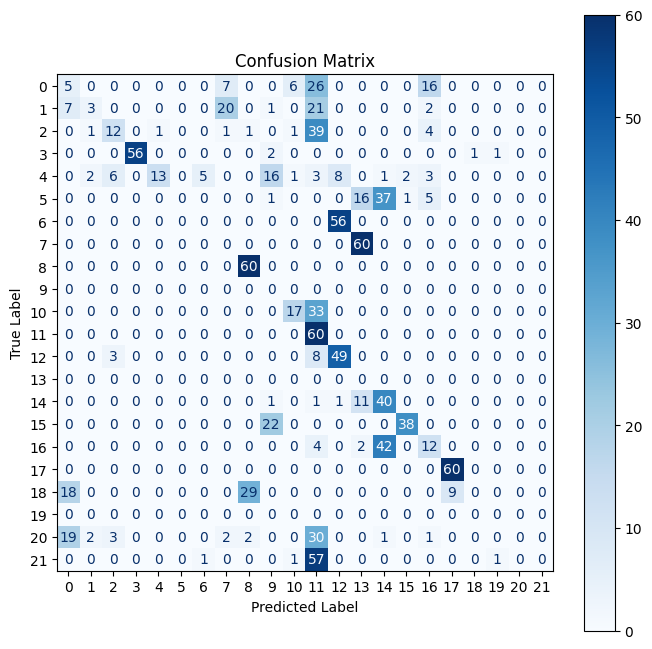

Acurácia: 0.38


In [24]:
print_scores(grid_search_knn, X_test, y_test, figsize=(8,8))

### Testes - KNN -Binary

In [25]:
grid_search = GridSearchCV(knn, parametersKnn, cv=folds)
grid_search.fit(X_train_bin, y_train_bin)


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9]})

Best parameters found:  {'metric': 'euclidean', 'n_neighbors': 3}
Validation accuracy score: 0.84
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.66      1050
         1.0       0.10      1.00      0.18        60

    accuracy                           0.52      1110
   macro avg       0.55      0.75      0.42      1110
weighted avg       0.95      0.52      0.64      1110



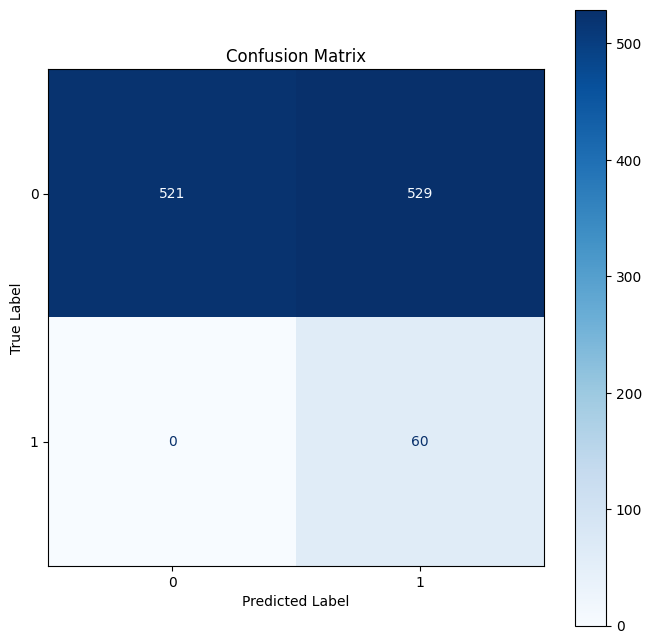

Acurácia: 0.52
F1 Score: 0.18


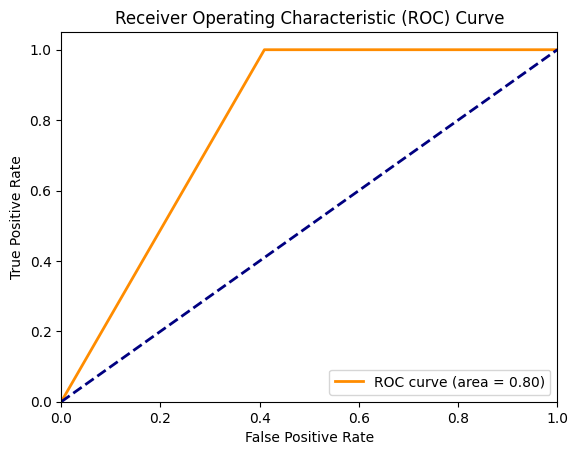

In [26]:

print_scores(grid_search, X_test, y_test_bin, figsize=(8,8))


### Testes - SVM -Multiclass

In [27]:
grid_search = GridSearchCV(svm, parametersSVM, cv=folds)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None),
             estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly']})

Best parameters found:  {'metric': 'euclidean', 'n_neighbors': 3}
Validation accuracy score: 0.89
              precision    recall  f1-score   support

         1.0       0.10      0.08      0.09        60
         2.0       0.38      0.06      0.10        54
         3.0       0.50      0.20      0.29        60
         4.0       1.00      0.93      0.97        60
         5.0       0.93      0.22      0.35        60
         6.0       0.00      0.00      0.00        60
         7.0       0.00      0.00      0.00        56
         8.0       0.00      0.00      0.00        60
        10.0       0.65      1.00      0.79        60
        12.0       0.65      0.34      0.45        50
        13.0       0.21      1.00      0.35        60
        14.0       0.43      0.82      0.56        60
        16.0       0.33      0.74      0.46        54
        17.0       0.93      0.63      0.75        60
        18.0       0.28      0.20      0.23        60
        19.0       0.87      1.00    

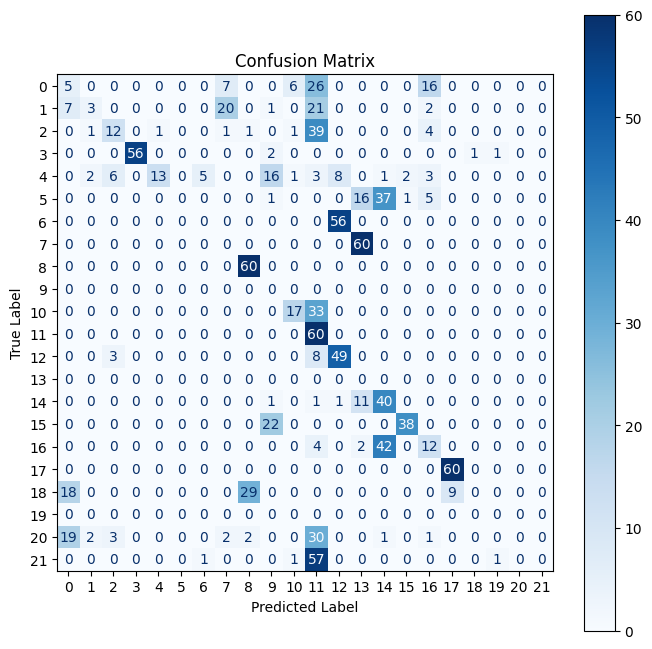

Acurácia: 0.38


In [28]:
print_scores(grid_search_knn, X_test, y_test, figsize=(8,8))

### Testes - SVM -Binary

In [29]:
grid_search = GridSearchCV(svm, parametersSVM, cv=folds)
grid_search.fit(X_train_bin, y_train_bin)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None),
             estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly']})

Best parameters found:  {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
Validation accuracy score: 0.94
              precision    recall  f1-score   support

         0.0       1.00      0.63      0.77      1050
         1.0       0.13      1.00      0.24        60

    accuracy                           0.65      1110
   macro avg       0.57      0.82      0.51      1110
weighted avg       0.95      0.65      0.75      1110



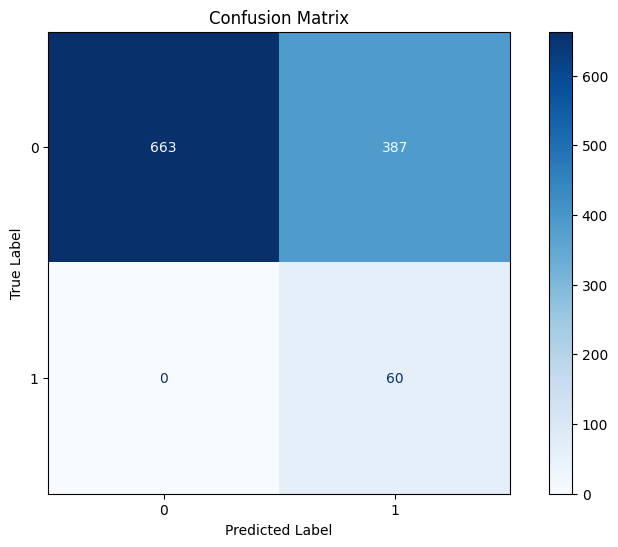

Acurácia: 0.65
F1 Score: 0.24


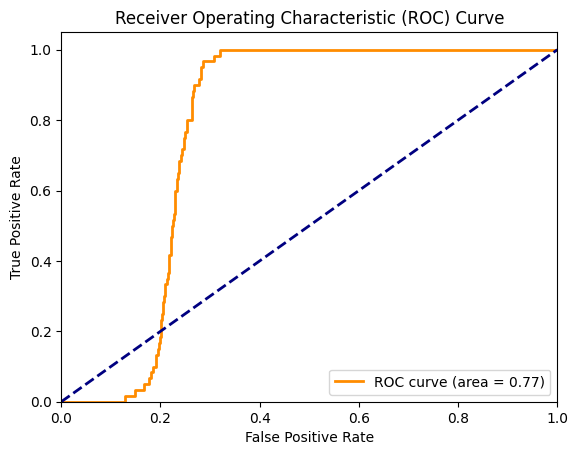

In [30]:
print_scores(grid_search, X_test, y_test_bin)

### Testes - SVM VS Rest -Multiclass

In [31]:
parametersSVMRest  = {}
folds = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

grid_search = GridSearchCV(ovr,parametersSVMRest, cv=folds)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None),
             estimator=OneVsRestClassifier(estimator=SVC(C=1, gamma=1,
                                                         kernel='linear',
                                                         probability=True)),
             param_grid={})

Best parameters found:  {}
Validation accuracy score: 0.82
              precision    recall  f1-score   support

         1.0       0.35      0.20      0.26        60
         2.0       0.05      0.02      0.03        54
         3.0       0.20      0.22      0.21        60
         4.0       0.93      0.47      0.62        60
         5.0       0.44      0.35      0.39        60
         6.0       0.00      0.00      0.00        60
         7.0       0.00      0.00      0.00        56
         8.0       0.00      0.00      0.00        60
        10.0       0.98      0.80      0.88        60
        12.0       0.54      0.84      0.66        50
        13.0       0.34      0.47      0.39        60
        14.0       0.31      0.50      0.38        60
        16.0       0.25      0.65      0.36        54
        17.0       0.84      0.72      0.77        60
        18.0       0.31      0.22      0.25        60
        19.0       0.73      0.77      0.75        60
        20.0       0.0

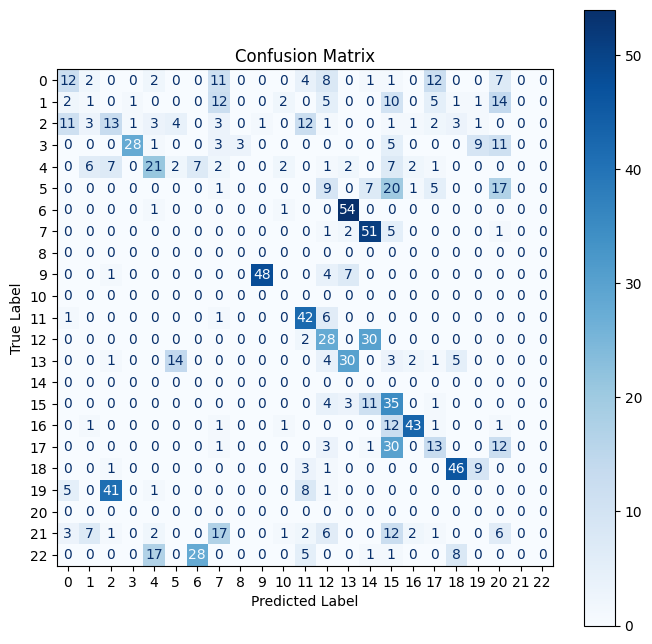

Acurácia: 0.32


In [32]:
print_scores(grid_search, X_test, y_test, figsize=(8,8))

### Testes - SVM VS Rest - Binary

In [33]:
grid_search = GridSearchCV(ovr, parametersSVMRest, cv=folds)
grid_search.fit(X_train_bin, y_train_bin)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None),
             estimator=OneVsRestClassifier(estimator=SVC(C=1, gamma=1,
                                                         kernel='linear',
                                                         probability=True)),
             param_grid={})

Best parameters found:  {}
Validation accuracy score: 0.94
              precision    recall  f1-score   support

         0.0       1.00      0.51      0.68      1050
         1.0       0.10      1.00      0.19        60

    accuracy                           0.54      1110
   macro avg       0.55      0.76      0.43      1110
weighted avg       0.95      0.54      0.65      1110



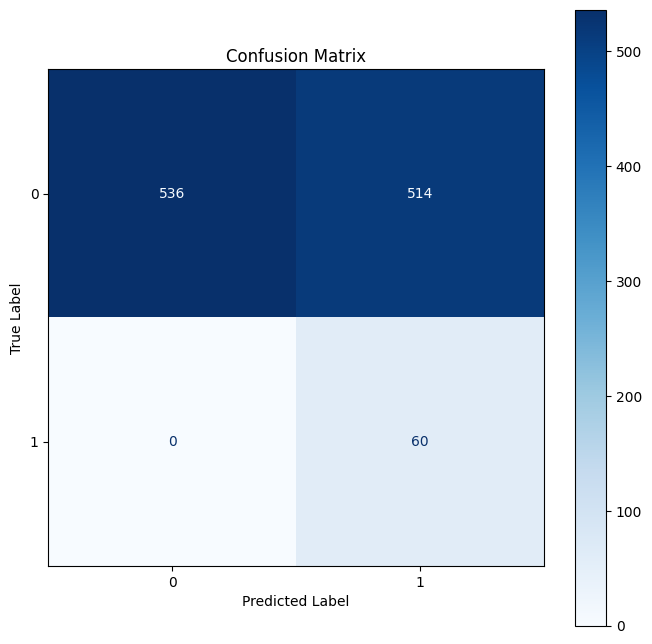

Acurácia: 0.54
F1 Score: 0.19


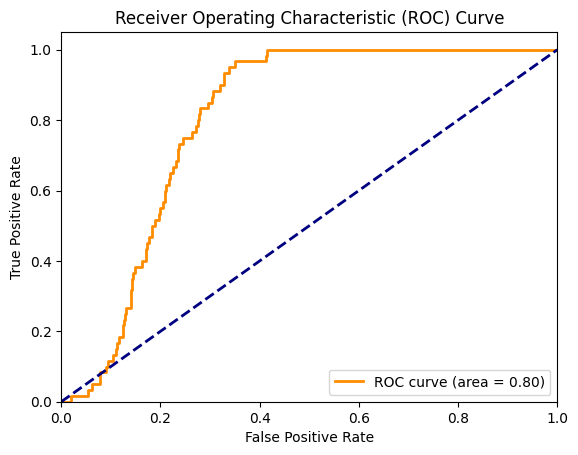

In [34]:
print_scores(grid_search, X_test, y_test_bin, figsize=(8,8))

## 8.Análise dos Resultados  <a id="resultados"></a>

#### Em comparação de dados obtidos em diferentes momentos temporais apresenta um desafio significativo na obtenção de resultados fidedignos. Esta variação temporal combinado com as diferenças individuais entre participantes, destaca a importância de balancear adequadamente os dados. Em termos de resultados, conseguimos identificar grande parte dos participantes, embora alguns apresentem variações consideráveis, além de um elevado nível de ruído nos sinais. Esse ruído dificulta a extração de características para uma boa classificação. 